Dataset shape: (155, 35)

Summary stats:
         Activity ID  Max. Elevation (Raw)  Min. Elevation (Raw)  \
count  1.550000e+02            155.000000            155.000000   
mean   1.534023e+09            383.125613            383.125613   
std    2.847469e+08            117.063615            117.063615   
min    9.083326e+08            159.800000            159.800000   
25%    1.297725e+09            307.245000            307.245000   
50%    1.449839e+09            326.680000            326.680000   
75%    1.743754e+09            456.705000            456.705000   
max    2.284659e+09            756.600000            756.600000   

       Elevation Gain (Raw)  Elevation Loss (Raw)  Average Heart Rate (bpm)  \
count            155.000000            155.000000                155.000000   
mean             158.055097            158.407484                174.148387   
std              119.421463            118.436687                  5.275271   
min                3.000000           

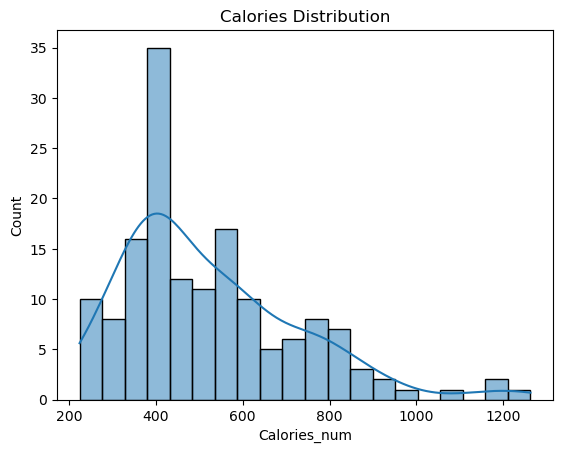

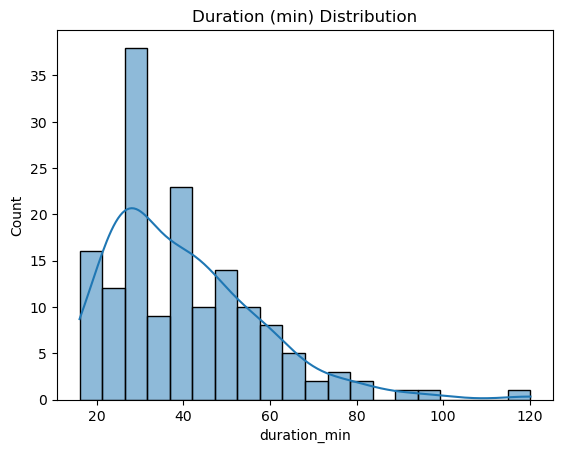

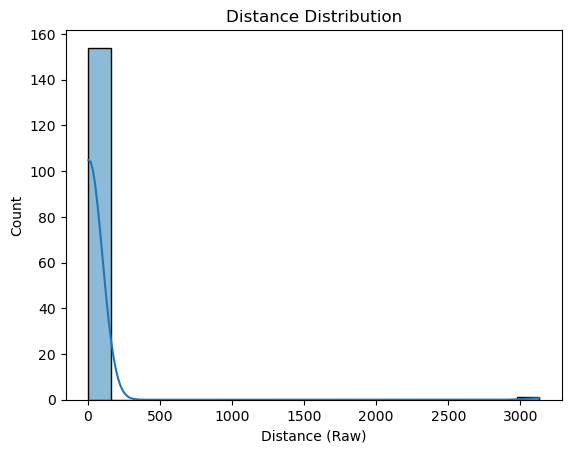

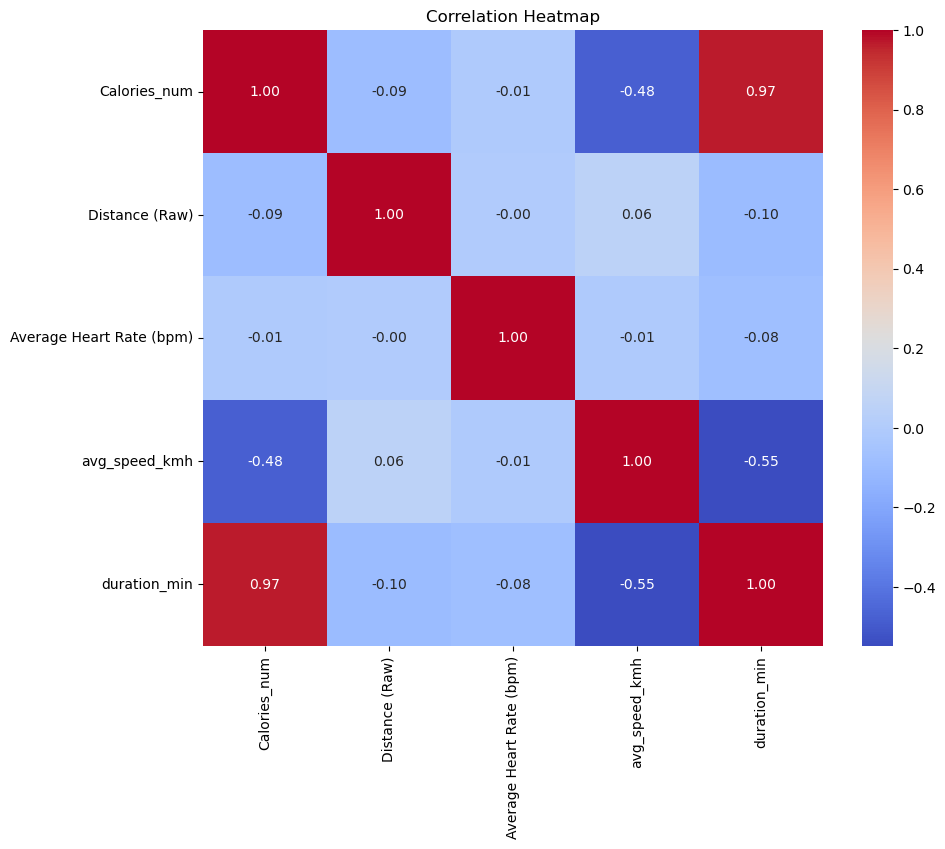

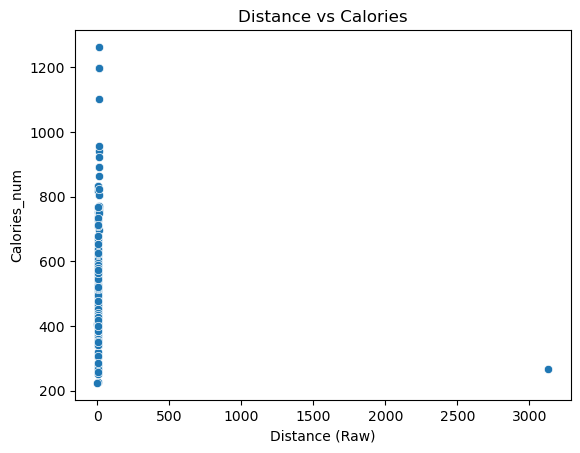

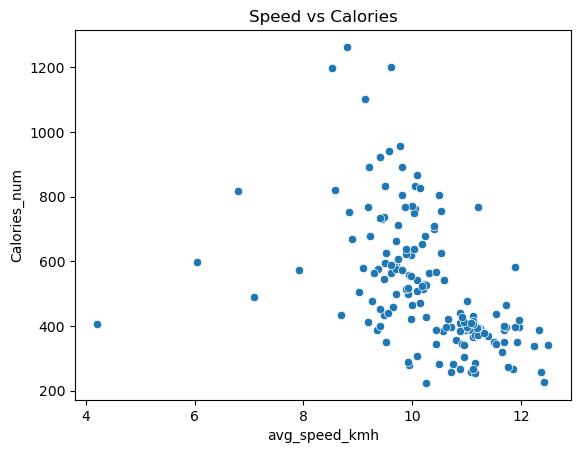

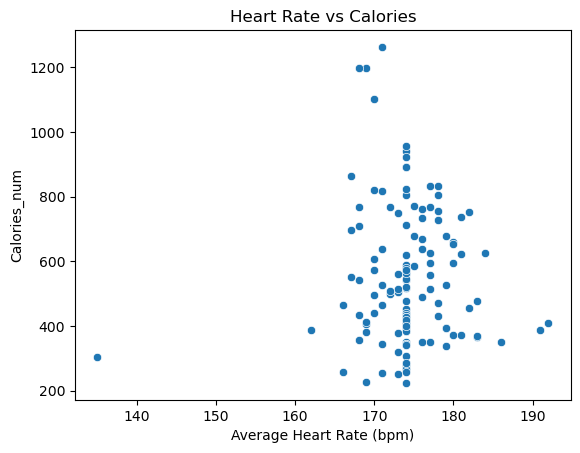

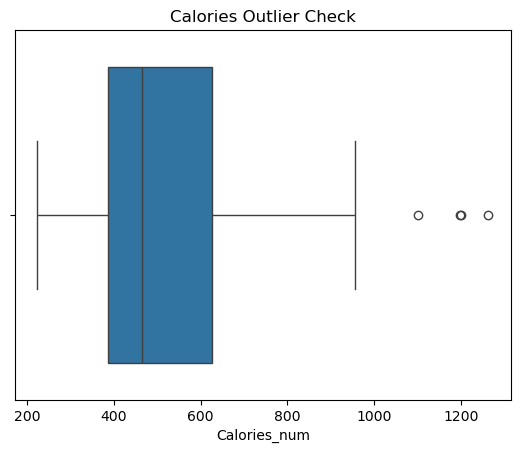

LinearRegression: R2=-15833.906 ± 25414.700
PolynomialRegression(d=2): R2=-393620815044.956 ± 786722807232.439
SVR(RBF): R2=0.297 ± 0.174
RandomForest: R2=0.878 ± 0.074


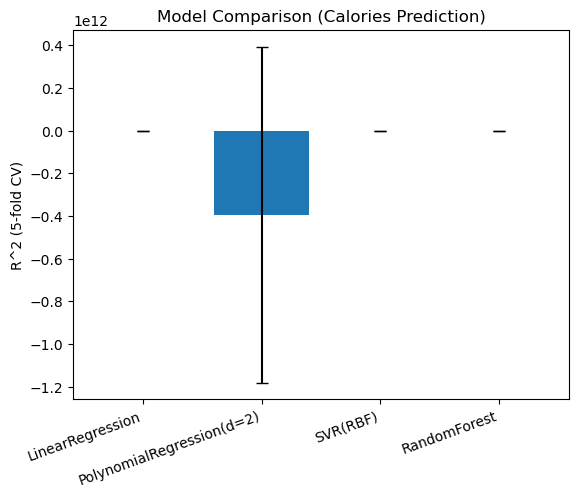

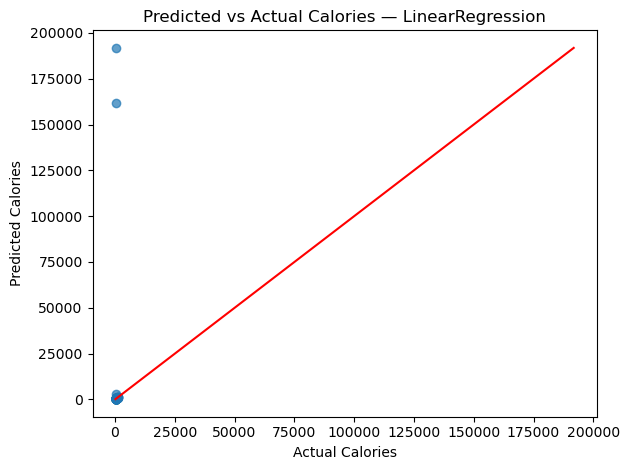

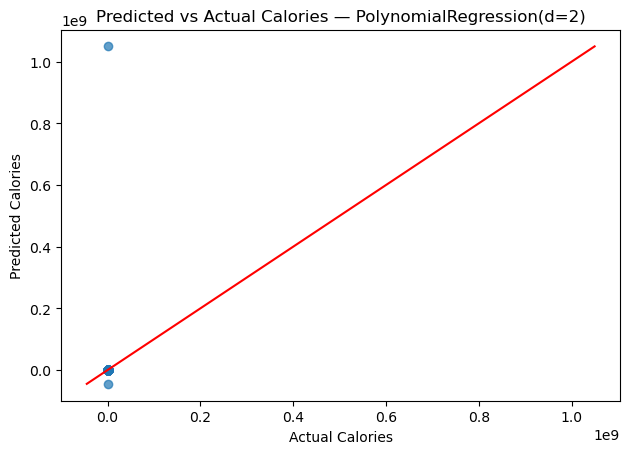

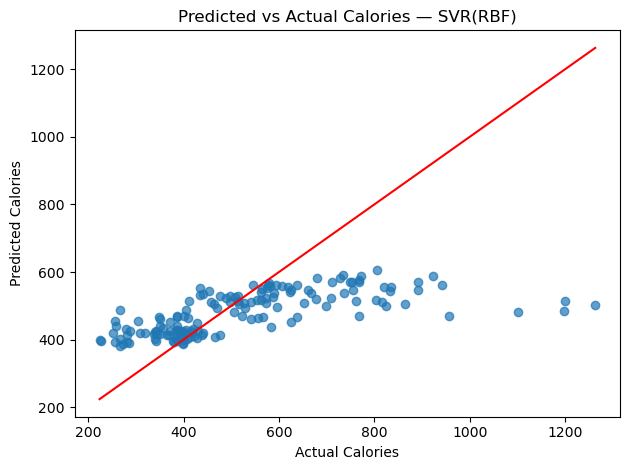

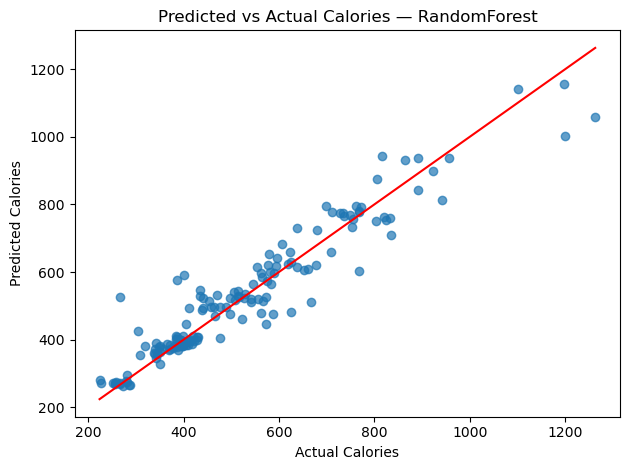

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

# -------------------------
# Helper functions
# -------------------------
def pace_to_speed_kmh(pace_str: str) -> float:
    """Convert pace MM:SS per km to speed in km/h"""
    try:
        if isinstance(pace_str, str) and ":" in pace_str:
            mm, ss = pace_str.strip().split(":")
            minutes = float(mm) + float(ss)/60.0
            if minutes == 0:
                return np.nan
            return 60.0 / minutes
        return np.nan
    except:
        return np.nan

def hms_to_minutes(hms: str) -> float:
    """Convert HH:MM:SS to total minutes"""
    try:
        if isinstance(hms, str) and hms.count(":") == 2:
            h, m, s = hms.strip().split(":")
            return int(h)*60 + int(m) + int(s)/60.0
        return np.nan
    except:
        return np.nan

def clean_calories(val) -> float:
    """Remove commas and cast to float"""
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        val = val.replace(",", "").strip()
    try:
        return float(val)
    except:
        return np.nan

# -------------------------
# Load and preprocess data
# -------------------------
path = "activities_cleaned 1.csv"  # change to your dataset path
df = pd.read_csv(path)

# Feature engineering
df["avg_speed_kmh"] = df["Average Speed"].apply(pace_to_speed_kmh)
df["avg_moving_speed_kmh"] = df["Average Moving Speed"].apply(pace_to_speed_kmh)
df["max_speed_kmh"] = df["Max. Speed"].apply(pace_to_speed_kmh)
df["duration_min"] = df["Duration (h:m:s)"].apply(hms_to_minutes)
df["moving_duration_min"] = df["Moving Duration (h:m:s)"].apply(hms_to_minutes)
df["Calories_num"] = df["Calories"].apply(clean_calories)
df["RainfallBin"] = df["Rainfall"].map({"yes": 1, "no": 0}).fillna(0).astype(int)

df = df.dropna(subset=["Calories_num"]).copy()

# -------------------------
# Exploratory Data Analysis
# -------------------------
print("Dataset shape:", df.shape)
print("\nSummary stats:\n", df.describe())

# Distribution plots
plt.figure()
sns.histplot(df["Calories_num"], bins=20, kde=True)
plt.title("Calories Distribution")

plt.figure()
sns.histplot(df["duration_min"], bins=20, kde=True)
plt.title("Duration (min) Distribution")

plt.figure()
sns.histplot(df["Distance (Raw)"], bins=20, kde=True)
plt.title("Distance Distribution")

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[["Calories_num","Distance (Raw)","Average Heart Rate (bpm)",
                "avg_speed_kmh","duration_min"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")

# Scatter plots
plt.figure()
sns.scatterplot(x="Distance (Raw)", y="Calories_num", data=df)
plt.title("Distance vs Calories")

plt.figure()
sns.scatterplot(x="avg_speed_kmh", y="Calories_num", data=df)
plt.title("Speed vs Calories")

plt.figure()
sns.scatterplot(x="Average Heart Rate (bpm)", y="Calories_num", data=df)
plt.title("Heart Rate vs Calories")

# Outlier detection (boxplot)
plt.figure()
sns.boxplot(x=df["Calories_num"])
plt.title("Calories Outlier Check")

plt.show()

# -------------------------
# Modeling
# -------------------------
numeric_features = [
    "Max. Elevation (Raw)","Min. Elevation (Raw)","Elevation Gain (Raw)","Elevation Loss (Raw)",
    "Average Heart Rate (bpm)","Max. Heart Rate (bpm).1","Distance (Raw)",
    "avg_speed_kmh","avg_moving_speed_kmh","max_speed_kmh",
    "duration_min","moving_duration_min","Temperature (Raw)","Wind Speed (Raw)","Humidity (Raw)","RainfallBin"
]

categorical_features = ["Activity Type","Condition","Wind Direction"]

X = df[numeric_features + categorical_features].replace([np.inf, -np.inf], np.nan)
y = df["Calories_num"].values

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

poly_preprocessor = ColumnTransformer([
    ("num_poly", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False))
    ]), numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

models = {
    "LinearRegression": Pipeline([("prep", preprocessor), ("model", LinearRegression())]),
    "PolynomialRegression(d=2)": Pipeline([("prep_poly", poly_preprocessor), ("model", LinearRegression())]),
    "SVR(RBF)": Pipeline([("prep", preprocessor), ("model", SVR(kernel="rbf", C=10.0, epsilon=0.2))]),
    "RandomForest": Pipeline([("prep", preprocessor), ("model", RandomForestRegressor(n_estimators=300, random_state=42))])
}

# -------------------------
# Cross-validation
# -------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
for name, pipe in models.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
    cv_results[name] = (np.mean(scores), np.std(scores))
    print(f"{name}: R2={np.mean(scores):.3f} ± {np.std(scores):.3f}")

# Bar chart comparison
names = list(cv_results.keys())
means = [cv_results[n][0] for n in names]
stds = [cv_results[n][1] for n in names]

plt.figure()
plt.bar(range(len(names)), means, yerr=stds, capsize=4)
plt.xticks(range(len(names)), names, rotation=20, ha="right")
plt.ylabel("R^2 (5-fold CV)")
plt.title("Model Comparison (Calories Prediction)")
plt.show()

# -------------------------
# Predicted vs Actual scatter for best models
# -------------------------
for name, pipe in models.items():
    y_pred = cross_val_predict(pipe, X, y, cv=cv)
    plt.figure()
    plt.scatter(y, y_pred, alpha=0.7)
    mn, mx = min(y.min(), y_pred.min()), max(y.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], color="red")
    plt.title(f"Predicted vs Actual Calories — {name}")
    plt.xlabel("Actual Calories")
    plt.ylabel("Predicted Calories")
    plt.tight_layout()
    plt.show()
